**Table of contents**<a id='toc0_'></a>    
- [Visibility](#toc1_)    
  - [I. Usability elements](#toc1_1_)    
    - [I.1 Angle classes](#toc1_1_1_)    
    - [I.2 Interpolation](#toc1_1_2_)    
  - [II. Time](#toc1_2_)    
    - [II.1 Time correction](#toc1_2_1_)    
    - [II.2 Classes for time and date](#toc1_2_2_)    
    - [II.3 Sidereal Time](#toc1_2_3_)    
      - [II.3.1 Greenwich HA](#toc1_2_3_1_)    
      - [II.3.2 LST](#toc1_2_3_2_)    
  - [III. Trajectory along the sky](#toc1_3_)    
    - [III.1 Coordinates](#toc1_3_1_)    
    - [III.2 Compute trajectory](#toc1_3_2_)    
      - [III.2.1 Precession](#toc1_3_2_1_)    
      - [III.2.2 Nutation](#toc1_3_2_2_)    
      - [III.2.3 Refraction](#toc1_3_2_3_)    
      - [III.2.4 Motion along the sky](#toc1_3_2_4_)    
    - [III.2.5 Transit, rising and setting](#toc1_3_3_)    
  - [IV. Sun](#toc1_4_)    
    - [IV.I Twilight](#toc1_4_1_)    
  - [V. Moon](#toc1_5_)    
    - [V.I Moon Phases](#toc1_5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Visibility](#toc0_)

## <a id='toc1_1_'></a>[I. Usability elements](#toc0_)

Importing required packages and defining functions to extract data from data files in `/data/`. 

In [2]:
## required packages
import os.path as ph
from os import getcwd
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

# collecting paths of directories
PROJECT_FOLDER = ph.split(getcwd())[0]
DATA_FOLDER = ph.join(PROJECT_FOLDER,'data')


In [3]:
def get_data(filename: str, unpack: bool = True, delimiter: str = ',', message: bool = False) -> np.ndarray:
    """Extracting data from `.csv` or `.txt` files.

    Function takes the name of a data file in `/data` directory and extracts data.

    :param filename: name of the data filter
    :type filename: str
    :param unpack: parameter of `np.loadtxt()`, defaults to `True`
    :type unpack: bool, optional
    :param delimiter: only for `.csv` files, the delimiter between data, defaults to `','`
    :type delimiter: str, optional
    :param message: control parameter, if it is `True` update message will be printed, defaults to `False`
    :type message: bool, optional
    :raises Exception: only `.txt` and `.csv` files are allowed
    
    :return: extracted data
    :rtype: np.ndarray
    """
    # file path
    DATA_FILE = ph.join(DATA_FOLDER,filename)
    if message:
        print('> Open file: ' + DATA_FILE)
    # getting extension of the file 
    ext = filename[-3:]
    if ext == 'csv':
        from pandas import read_csv
        data = read_csv(DATA_FILE, delimiter=delimiter).to_numpy().transpose()
    elif ext == 'txt':
        data = np.loadtxt(DATA_FILE,unpack=unpack)
    else: raise Exception(f'.{ext} is not allowed!\nOnly .txt or .csv files')
    return data

def import_data(filename: str, sel: int | np.ndarray | slice = slice(None), delimiter: str =',', sep: str = ':') -> tuple[np.ndarray]:
    """Extracting target data.

    Functions extracts data for target object(s) as name (`names`), right ascension (`ras`), 
    declination (`decs`) and proper motion (`muas`, `muds`).

    For multiple objects it is possible to select just some, for which data are extracted, 
    through `sel` parameter.

    The standard format for angles (times) is a string:
    `'degrees:primes:seconds.seconds'` (`'hh:mm:ss.ss'`)

      The parameter `sep` is the character separates different units (in this case `':'`) 

    :param filename: name of the data file
    :type filename: str
    :param sel: parameter to select object for which data are extracted, defaults to `slice(None)`
    :type sel: int | np.ndarray | slice, optional
    :param delimiter: only for `.csv` files, the delimiter between data, defaults to `','`
    :type delimiter: str, optional
    :param sep: character to separate different unit, defaults to `':'`
    :type sep: str, optional
    
    :return: extracted data
    :rtype: tuple[np.ndarray]
    """
    # extracting data
    names, ras, decs, muas, muds = get_data(filename,delimiter=delimiter)
    # defining an empty list for proper motion data
    prmts = []
    for i in range(len(names)):
        alpha = ras[i]
        delta = decs[i]
        mua = muas[i]
        mud = muds[i]

        ras[i] = [alpha[0],[float(val) for val in alpha[1:].split(sep)]]
        decs[i] = [delta[0],[float(val) for val in delta[1:].split(sep)]]
        
        mua = float(mua) if mua != 'None' else None
        mud = float(mud) if mud != 'None' else None
        prmts += [[mua,mud]]
    
    return names[sel], ras[sel], decs[sel], prmts[sel]


### <a id='toc1_1_1_'></a>[I.1 Angle classes](#toc0_)

To handle the different units in which one can express the value of an angle on celestial sphere (radiants, degrees, hours), two classes of object are defined: `Angles` and `HAngles`. These keep the value of an angle in different units and provide some useful functions and method to manipulate angles. 

Angle values in degrees or in hours are stored as float type. However, it is possible to pass a _list angle_, that is a list made by a string and a 3d array: the first is the sign, the second stores the values for degrees (hours), primes (minutes) and seconds.

_Example_: $12^{\circ}11'19''$
  * **float angle**: `12.1886` degrees
  * **list angle**: `[ '+', np.array([12,11,19]) ]`

_Example_: $-21h08m31s$
  * **float angle**: `-21.1419` hours
  * **list angle**: `[ '-', np.array([21,8,31]) ]` 

In [4]:
class Angles():
    """Class to handle with angles in degrees or radiants.
    
    The class takes the value of an angle in deg or rad,
    converts one in the other and stored the values.

    The attributes of the class are:

    :ivar rad: the value of the angle in radiants
    :vartype rad: float | None
    :ivar deg: the value of the angle in deg
    :vartype deg: float    
    :ivar lim: the angle is in a range set by [0,`lim`] (see `std_format()` docstring)
    :vartype lim: int

    .. note::
        It is possible to generate a null angle, that is an empty `Angles` object 
        (`self.deg = None` and `self.rad = None`), through the command `Angles(None)`. 
    """

    #: a dictionary to pass from string symbol to integer and vice versa
    strsign = { '+' :  1,
                '-' : -1,
                 1  : '+',
                -1  : '-' }

    @staticmethod
    def decimal(ang: np.ndarray | list) -> float:
        """Function to convert a list angle
        [val, val, val.val] in a float 
        val.val in degrees or hours

        :param ang: angle array value in deg or hms
        :type ang: np.ndarray | list
        
        :return: angle float value
        :rtype: float
        """
        if sum(ang) == 0: return 0
        else: return ang[0] + ang[1]/60 + ang[2]/3600
    
    @staticmethod
    def deg_to_rad(deg: float | np.ndarray) -> float | np.ndarray:
        """Function to convert deg in rad

        :param deg: angle in deg
        :type deg: float | np.ndarray

        :return: value in rad
        :rtype: float | np.ndarray
        """
        # computing radiants
        rad = deg * pi / 180
        return rad

    @staticmethod
    def rad_to_deg(rad: float | np.ndarray) -> float | np.ndarray:
        """Function to convert rad in deg

        :param rad: value in rad
        :type rad: float | np.ndarray
        
        :return: angle in deg
        :rtype: float | np.ndarray
        """
        # computing degrees
        deg = rad * 180 / pi
        return deg

    @staticmethod
    def std_format(deg: float, lim: int) -> list:
        """Function to trasform a float angle in a list angle 

        The wanted format is: [`sign`, [deg (<`lim`), pp (<60), ss.ss (<60)]]

        The value of the angle is in a range set by the `lim` value.
        
        :param deg: float angle
        :type deg: float
        :param lim: limit value
        :type lim: int

        :return: list angle
        :rtype: list
        """
        # storing value of the angle
        ang = deg
        # null angle condition
        if ang == 0.:
            return ['+',np.zeros(3,dtype=int)]
        else:
            # taking the sign as a str
            sign = Angles.strsign[np.sign(ang)]
            # taking the absolute value
            ang = abs(ang)
            # edge condition
            if ang > lim:
                ang -= lim * (ang // lim)
            # degrees
            val = [np.trunc(ang).astype(int)]
            # primes
            val += [np.trunc(ang % 1 * 60).astype(int)]
            # seconds
            val += [round(ang % 1 * 60 % 1 * 60,4)]
            return [sign, np.array(val)]
    
    @staticmethod
    def str_angle(deg: float, rad: float, lim: int, sel: str = 'all', unit: bool = False) -> str:
        """Function to get a string to print the value of an angle
        
        One can select to print the angle in all 
        units or just one through the `sel`
        parameter:

            * `sel = 'all'`: print value in all units
            * `sel = 'deg'`: print value in deg
            * `sel = 'rad'`: print value in rad

        :param deg: value in deg        
        :type deg: float        
        :param rad: value in rad        
        :type rad: float        
        :param lim: limit value
        :type lim: int
        :param sel: to select in which unit printing the angle, defaults to `'all'`
        :type sel: str, optional
        :param unit: if `True` also the unit name is printed, defaults to `False`
        :type unit: bool, optional
        :raises Exception: the only allowed values for `sel` parameter are in this docstring

        :return: the string with the values
        :rtype: str
        """
        # getting list angle fotmat
        deg = Angles.std_format(deg,lim)
        # collecting string for each unit
        dd, mm, ss = deg[1]
        deg_str = deg[0]+f'[{dd:.0f}, {mm:.0f}, {ss:.4f}]'
        rad_str = f'{rad/pi} * pi'
        # condition to print unit names
        if unit:
            deg_str += ' deg'
            rad_str += ' rad'
        # selection condition
        if sel == 'deg': return deg_str
        elif sel == 'rad': return rad_str
        elif sel == 'all': return 'deg =\t' + deg_str + '\nrad =\t' + rad_str
        else: raise Exception(f"-> Error in `sel` parameter!\nsel = {sel} is not allowed\nRead the documentation for correct values of the parameter")

    def __init__(self, ang: float | list | None, unit: str, lim: int = 360) -> None:
        """Constructor of the class

        The function takes a value (`ang`) and the corrisponding 
        unit (`unit`) as input, computes and stores the angle
        values in deg and rad. 

        One can pass either a float or a list (see `std_format()` 
        docstring) angle.

        :param ang: angle value
        :type ang: float | list | None
        :param unit: unit of angle value, as `'deg'` or `'rad'`
        :type unit: str
        :param lim: angle edge (see `std_format()` docstring), defaults to `360`
        :type lim: int, optional
        """
        # setting lim
        self.lim = lim
        # condition for a null angle
        if ang is None:
            self.deg = None
            self.rad = None
        # value in radiants
        elif unit == 'rad':
            self.rad = ang
            self.deg = Angles.rad_to_deg(ang)
        # value in degrees
        elif unit == 'deg':
            # list format condition
            if type(ang) == list:
                # getting the sign
                sign = Angles.strsign[ang[0]]
                # converting in float
                self.deg = Angles.decimal(ang[1])*sign
            else:
                self.deg = ang
            self.rad = Angles.deg_to_rad(self.deg)

    def copy(self):
        """Function to get an exact copy of 
        an `Angles` object

        :return: copy of the angle
        :rtype: Angles
        """
        return Angles(self.deg,'deg',self.lim)

    def print_angle(self, sel: str = 'all', unit: bool = False) -> list[str] | str:
        """Function to print the angle value(s)

        :param sel: to select in which unit printing the angle, defaults to `'all'`
        :type sel: str, optional
        :param unit: if `True` also the unit name is printed, defaults to `False`
        :type unit: bool, optional
        
        :return: string (or list of strings) of angle value(s) to print
        :rtype: list[str] | str
        """
        ang = self.copy()
        # condition to generalize the method for not-array type
        if type(ang.deg) != np.ndarray:
            ang.deg = [ang.deg]
            ang.rad = [ang.rad]
        deg = ang.deg
        rad = ang.rad
        # defing the list of strings
        str_list = []
        for i in range(len(deg)):
            str_res = ''
            if sel == 'all' and len(deg) > 1:
                # for array of values printing the index
                str_res += f'ang {i}:\n'
            str_res += Angles.str_angle(deg[i], rad[i], ang.lim, sel=sel, unit=unit)
            str_list += [str_res]
        # only a string for not-array type
        if len(deg) == 1:
            str_list = str_res
        return str_list

    def __add__(self, angle):
        """Function to sum two angles

        :param angle: second angle or value
        :type angle: Angles | int | float

        :return: sum of the angles
        :rtype: Angles
        """
        # condition for values
        if isinstance(angle, (int,float)):
            # converting in `Angles` object
            angle = Angles(angle,'deg',self.lim)
        # checking the edges
        if self.lim != angle.lim:
            print(f'\n!warning: you are summing angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the sum in rad
        sumrad = self.rad + angle.rad
        return Angles(ang=sumrad,unit='rad',lim=self.lim)

    def __sub__(self, angle):
        """Function to subtract two angles

        :param angle: second angle or value
        :type angle: Angles | int | float

        :return: subtraction of the angles
        :rtype: Angles
        """
        # condition for values
        if isinstance(angle, (int,float)):
            # converting in `Angles` object
            angle = Angles(angle,'deg',self.lim)
        # check for edges
        if self.lim != angle.lim:
            print(f'\n!warning: you are subtracting angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the subtraction in rad
        subrad = self.rad - angle.rad
        return Angles(ang=subrad,unit='rad',lim=self.lim)

    def __mul__(self,val: float | int | np.ndarray):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int | np.ndarray

        :return: angle-number product
        :rtype: Angles
        """
        return Angles(self.rad*val,'rad',lim=self.lim)
    
    def __neg__(self):
        """Function to compute opposite angle

        :return: the opposite angle
        :rtype: Angles
        """
        return self * -1



class HAngles(Angles):
    """This is essentially the same class as :class: `Angles`, taking account 
    of the description of an angle in [hours, minutes, seconds] format.

    The attributes are:

    :ivar rad: from :class: `Angles`; the value of the angle in rad 
    :vartype rad: float
    :ivar deg: from :class: `Angles`; the value of the angle in deg 
    :vartype deg: float    
    :ivar deg: the value of the angle in hours
    :vartype deg: float  
    :ivar lim: from :class: `Angles`; the angle is in a range set by [0,`lim`] (see `std_format()` docstring)
    :vartype lim: int

    .. note::
        It is possible to generate a null angle, that is an empty `HAngles` variable
        (`self.deg = None`, `self.rad = None` and `self.hms = None`), through the 
        command `HAngles(None)`. 
    """

    @staticmethod
    def deg_to_hms(deg: float | np.ndarray) -> float | np.ndarray:
        """Function to convert deg in hours

        1 hour = 15 degrees

        :param deg: angle in deg
        :type deg: float | np.ndarray

        :return: angle in hours
        :rtype: float | np.ndarray
        """
        hms = deg / 15
        return hms
    
    @staticmethod
    def hms_to_deg(hms: float | np.ndarray) -> float | np.ndarray:
        """Function to convert hours in deg

        1 hour = 15 degrees

        :param hms: angle in hours
        :type hms: float | np.ndarray

        :return: angle in deg
        :rtype: float | np.ndarray
        """
        deg = hms * 15
        return deg
    
    @staticmethod
    def rad_to_hms(rad: float | np.ndarray) -> float | np.ndarray:
        """Function to convert rad in hours

        It pass through the `rad_to_deg()` and
        `deg_to_hms()` functions

        :param rad: angle value in rad
        :type rad: float | np.ndarray

        :return: angle in hours
        :rtype: float | np.ndarray
        """
        deg = Angles.rad_to_deg(rad)
        hms = HAngles.deg_to_hms(deg)
        return hms
    
    @staticmethod
    def hms_to_rad(hms: float | np.ndarray) -> float | np.ndarray:
        """Function to convert hours in rad

        It pass through the `hms_to_deg()` and
        `deg_to_rad()` functions

        :param rad: angle in hours
        :type rad: float | np.ndarray

        :return: angle value in rad 
        :rtype: float | np.ndarray
        """
        deg = HAngles.hms_to_deg(hms)
        rad = Angles.deg_to_rad(deg)
        return rad

    @staticmethod
    def str_angle(deg: float, rad: float, hms: float, lim: int, sel: str = 'all', unit: bool = False) -> str:
        """Function to get a string to print the value of an angle
        (inherited from :class: `Angles`)

        One can select to print the angle in all 
        units or just one through the `sel`
        parameter:

            * `sel = 'all'`: print value in all units
            * `sel = 'deg'`: print value in deg
            * `sel = 'rad'`: print value in rad
            * `sel = 'hms'`: print value in hms

        :param deg: value in deg        
        :type deg: float        
        :param rad: value in rad        
        :type rad: float        
        :param hms: value in hours        
        :type hms: float
        :param lim: limit value
        :type lim: int
        :param sel: to select in which unit printing the angle, defaults to `'all'`
        :type sel: str, optional
        :param unit: if `True` also the unit name is printed, defaults to `False`
        :type unit: bool, optional
        :raises Exception: the only allowed values for `sel` parameter are in this docstring

        :return: the string with the values
        :rtype: str
        """
        # getting list angle fotmat
        hms = Angles.std_format(hms,lim/15)
        # collecting string for each unit
        hh, mm, ss = hms[1]
        hms_str = hms[0]+f'[{hh:.0f}, {mm:.0f}, {ss:.4f}]'
        # condition to print unit names
        if unit:
            hms_str += ' hms'
        # selection condition
        if sel == 'hms': return hms_str
        elif sel == 'all': return  Angles.str_angle(deg, rad, lim, sel=sel, unit=unit) + '\nhms = \t' + hms_str
        else: return Angles.str_angle(deg, rad, lim, sel=sel, unit=unit)
    
    def __init__(self, ang: float | list | None, unit: str, lim: int = 360):
        """Constructor of the class (inherited from :class: `Angles`)

        The function takes a value (`ang`) and the corrisponding 
        unit (`unit`) as input, computes and stores the angle
        values in deg, rad and hours. 

        One can pass either a float or a list (see `std_format()` 
        docstring) angle.

        :param ang: angle value
        :type ang: float | list | None
        :param unit: unit of angle value, like `'deg'`, `'rad'` or `'hms'`
        :type unit: str
        :param lim: angle edge (see `std_format()` docstring), defaults to `360`
        :type lim: int, optional
        """
        # `Angles.__init__()` function
        super().__init__(ang, unit, lim)
        # condition for a null angle 
        if ang is None:
            self.hms = None
        # angle in hms
        elif unit == 'hms':
            # list format condition
            if type(ang) == list:
                # getting the sign
                sign = Angles.strsign[ang[0]]
                # converting in float
                self.hms = Angles.decimal(ang[1])*sign
            else:
                self.hms = ang
            self.deg = HAngles.hms_to_deg(self.hms)
            self.rad = HAngles.hms_to_rad(self.hms)
        # angle in rad or deg
        else:
            self.hms = HAngles.deg_to_hms(self.deg)

    def copy(self):
        """Function to get an exact copy of 
        an `HAngles` object

        :return: copy of the angle
        :rtype: HAngles
        """
        return HAngles(self.deg,'deg',self.lim)
    
    def print_angle(self, sel: str = 'all', unit: bool = False) -> list[str] | str:
        """Function to print the angle value(s)

        :param sel: to select in which unit printing the angle, defaults to `'all'`
        :type sel: str, optional
        :param unit: if `True` also the unit name is printed, defaults to `False`
        :type unit: bool, optional
        
        :return: string (or list of strings) of angle value(s) to print
        :rtype: list[str] | str
        """
        ang = self.copy()
        # condition to generalize the method for not-array type
        if type(ang.deg) != np.ndarray:
            ang.deg = [ang.deg]
            ang.rad = [ang.rad]
            ang.hms = [ang.hms]
        deg = ang.deg
        rad = ang.rad
        hms = ang.hms
        # defing the list of strings
        str_list = []
        for i in range(len(deg)):
            str_res = ''
            if sel == 'all' and len(deg) > 1:
                # for array of values printing the index
                str_res += f'ang {i}:\n'
            str_res += HAngles.str_angle(deg[i], rad[i], hms[i], ang.lim, sel=sel, unit=unit)
            str_list += [str_res]
        # only a string for not-array type
        if len(deg) == 1:
            str_list = str_res
        return str_list
    
    def __add__(self, angle):
        """Function to sum two angles

        :param angle: second angle or value
        :type angle: HAngles | Angles | int | float

        :return: sum of the angles
        :rtype: HAngles
        """
        # condition for values
        if isinstance(angle, (int,float)):
            # converting in `HAngles` object
            angle = HAngles(angle,'deg',self.lim)
        # checking the edges
        if self.lim != angle.lim:
            print(f'-> Warning: you are summing angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the sum in rad
        sumrad = self.rad + angle.rad
        return HAngles(ang=sumrad,unit='rad',lim=self.lim)

    def __sub__(self, angle):
        """Function to subtract two angles

        :param angle: second angle or value
        :type angle: HAngles | Angles | int | float

        :return: subtraction of the angles
        :rtype: HAngles
        """
        # condition for values
        if isinstance(angle, (int,float)):
            # converting in `HAngles` object
            angle = HAngles(angle,'deg',self.lim)
        # checking the edges
        if self.lim != angle.lim:
            print(f'-> Warning: you are subtracting angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the subtaction in rad
        subrad = self.rad - angle.rad
        return HAngles(ang=subrad,unit='rad',lim=self.lim)

    def __mul__(self,val: float | int | np.ndarray):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int | np.ndarray

        :return: angle-number product
        :rtype: HAngles
        """
        return HAngles(self.rad*val,'rad',lim=self.lim)
    
    def __neg__(self):
        """Function to compute opposite angle

        :return: the opposite angle
        :rtype: HAngles
        """
        return self * -1



# defining some fixed angles
RIGHT = Angles( 90.,'deg')
FLAT  = Angles(180.,'deg')
ROUND = Angles(360.,'deg')


### <a id='toc1_1_2_'></a>[I.2 Interpolation](#toc0_)

For some quantities it is necessary to interpolate the value from a data table. In order to do that an interpolation function is implemented: the `interpole_three()` function interpolates value by three data points. This kind of interpolation is possible if the _third difference_ is _"small"_ (less than 3) only. 

Taking four points $y_1, y_2, y_3, y_4$, $D^{'}_{ij}\equiv y_j - y_i$ ($j = i+1$) and $D^{''}_{ijk} \equiv D^{'}_{jk} - D^{'}_{ij}$ ($j=i+1$ and $k=j+1$), the _third difference_ is $D^{'''}_{1234} \equiv D^{''}_{234} - D^{''}_{123} = D^{'}_{34} + D^{'}_{12} - 2D^{'}_{23}$     

In [5]:
def interpole_three(values: list | np.ndarray, centre: float | None = None, xvalues: list | np.ndarray | None = None, val: str | None = None, **kargs) -> float | tuple[float, dict]:
    """Computing interpolated value from three data points.

    If more than three points are passed, function computes third difference(s) in order to 
    check whether interpolation is possible or not.

    It possible to interpolate also extrema or zero points through the parameter `val`:

      * `val = None`: no additional result is returned
      * `val = 'ym'`: the extrema values and the corresponding interpolation parameter are computed
      * `val = 'n0'`: the interpolation parameter for zero point is computed
      * `val = 'all'`: both are computed

    For `val is not None` a dictionary with selected additional values are returned, in addition to the interpolated one. 

    To disable the warning messages one can use the parameter `warning = False` of kargs.

    :param values: y values from which interpolating
    :type values: list | np.ndarray
    :param centre: x value for which interpolating, defaults to `None`
    :type centre: float | None, optional
    :param xvalues: x values corrisponding to y values, defaults to `None`
    :type xvalues: list | np.ndarray | None, optional
    :param val: for additional results, defaults to `None`
    :type val: str | None, optional
    :param kargs: additional parameters
    :type kargs: Any 
    
    :return: the interpolated value and if `val is not None` selected additional results
    :rtype: float | tuple[float, dict]
    """
    # condition for warning messages
    if 'warning' in kargs.keys():
        warning = kargs['warning']
    else:
        warning = True
    
    # storing dimension and values
    dim = len(values)
    sample = np.copy(values)
    # condition for more than three values
    if dim > 3:
        # central value is necessary
        if centre == None: raise Exception('Error in central value!\n You have to pass the central value for interpolation')
        # also x values are necessary
        if len(xvalues) == 0: raise Exception('Error in `xval`!\n You have to pass x values for interpolation')
        # checking the magnitude of the third difference
        diff = np.diff(np.diff(np.diff(sample)))
        maxdiff = diff.max()
        if np.abs(maxdiff) > 3: 
            raise Exception(f'Error in interpolation!\nThe third difference is not negligible: {maxdiff}')
        # finding the index of the x value that is nearest to the `centre`
        idx = (np.abs(xvalues - centre)).argmin()
        # check for edges
        if idx == dim-1: idx -= 1
        elif idx == 0: idx += 1
        # cutting the sample to have only three elements
        # centered in central value
        sample = sample[idx-1:idx+2]
        xvalues = xvalues[idx-1:idx+2]
    # checking at least three values are passed
    elif dim < 3: 
        raise Exception('!Error in length!\nInterpolation needs three points at least')
    # getting the central value
    centre_val = sample[1]
    # computing differences
    a, b = np.diff(sample)
    c = b - a
    # central value is necessary
    if centre != None:
        # getting the x central value
        x2 = xvalues[1]
        # computing the interpolation factor
        n = (centre - x2)/np.abs(x2-xvalues[0])
        # computing the interpolated value
        result = centre_val + n/2 * (a + b + n*c) 
    else:
        if warning: 
            print(': No interpolation was done: parameter `centre` set to `None`')
        result = None

    # condition to compute additional quantities
    if val != None:
        # defining the dictionary for additional values
        dval = {}
        # condition to compute extrema through iterpolation
        if val == 'ym' or val == 'all':
            dval['ym'] = centre_val - (a+b)**2/(8*c)
            dval['nm'] = - (a+b) / (2*c)
        # condition to compute where function is null through iterpolation
        if val == 'n0' or val == 'all':
            # recursive method  
            n0 = 0
            cnt = 0     # control variable
            while True:
                dn0 = -(2*centre_val + n0*(a+b+c*n0))/(a+b+2*c*n0)
                n0 += dn0
                cnt += 1
                # condition to stop the loop
                if np.abs(dn0) < 1e-6:
                    break
                # control condition to prevent a Stack Overflow error
                if cnt > 20 and warning:
                    n0 = None 
                    print('Algorithm did not converge for n0!')
                    break
            dval['n0'] = n0 
        # appending the dictionary to the result
        result = (result, dval)
    return result


## <a id='toc1_2_'></a>[II. Time](#toc0_)


### <a id='toc1_2_1_'></a>[II.1 Time correction](#toc0_)

The difference between Universal Time (UT) and Dynamical Time (TD) need a direct measure. The `/data/dT_data.csv` file contains a table of values of $\Delta T = TD - UT$ for different years. If the year for the wanted $\Delta T$ is in $[1620,1998]$, but not in the table, the corresponding value will be obtained by interpolation. For the other years an empirical formula is used, instead.    

In [6]:
def time_correction(year: float | int, **kargs) -> float:
    """Computing the difference between TD and UT

    For years between 1620 and 1998 the 
    difference is computed through 
    interpolation from a data table (see
    `/data/dT_data.csv`)
    
    For years out that range an 
    approximated formula is used, instead

    :param year: year for which computing TD-UT
    :type year: float | int
    
    :return: TD - UT
    :rtype: float
    """
    # interpolation from data table
    if 1620 <= year <= 1998:
        # name of data file
        filename = 'dT_data.csv'
        # extracting data
        y0, dt0 = get_data(filename)
        # value is already in data
        if year in y0:
            dt = dt0[year == y0][0]
        # computing interpolation
        else:
            dt = interpole_three(dt0,centre=year,xvalues=y0,kargs=kargs)
    # approximated formula
    else:        
        t = (year - 2000)/100
        if year < 948:
            dt = 2177 + 497*t + 44.1*t**2
        else:
            dt =  102 + 102*t + 25.3*t**2
        if 2000 <= year <= 2100: dt += 0.37*(year-2100)
    return dt


### <a id='toc1_2_2_'></a>[II.2 Classes for time and date](#toc0_)

To handle with times and dates two classes are implemented:

  - **Time**
    
      This class stores the value of time in seconds and the information about what kind of time is (UT, TD or local time). 
  
  - **Date**

      In addition to the date and time, the corresponding Julian day is stored in this class. The information about the kind of calendar date and referred epoch are collected, too.
      If the wanted date is a local civil date, the constructor of the class computes date for UT, then it requires the information about time zone and daylight saving as input. 


In [7]:
class Time():
    """Class to store and manipolate time data

    The class takes value of time in seconds (or in [hh,mm,ss.ss])
    and the name of the kind of time to store them

    The attributes of the class are:

    :ivar val: the value of the angle in radiants
    :vartype val: float | np.ndarray | None
    :ivar tytime: the value of the angle in deg
    :vartype tytime: str    
    """

    #: the number of seconds in a day
    DAYSEC = 86400.

    @staticmethod
    def seconds(hh: int, mm: int, ss: float) -> float:
        """Function to convert time from [hh,mm,ss.ss] to seconds

        :param hh: hours
        :type hh: int
        :param mm: minutes
        :type mm: int
        :param ss: seconds
        :type ss: float
        
        :return: value in seconds only
        :rtype: float
        """
        return ss + mm*60 + hh*3600 
    
    @staticmethod
    def hms_form(time: float) -> list:
        """Function to convert time from seconds to [hh, mm (<60), ss.ss (<60)]

        :param time: value in seconds only
        :type time: float
        
        :return: value in [hh, mm (<60), ss.ss (<60)]
        :rtype: list
        """
        # getting seconds < 60
        # seconds are appoximated 
        ss = np.round(time % 60, 4)
        # getting minutes < 60
        mm = int((time // 60) % 60)
        # getting hours
        hh = int(time // 3600)
        # check
        if ss == 60: 
            ss -= 60
            mm += 1
        if mm == 60:
            mm -= 1
            hh += 1
        return [hh,mm,ss]
    
    @staticmethod
    def str_time(time: float, timetype: str, timezone: int = 0, dl_save: bool = False) -> str:
        """Function to get a string to print time value

        The format of the string is `'hh:mm:ss.ssss [timetype]'`.

        If the time is local civil one the time zone is printed, 
        instead of time type, like `'hh:mm:ss.ssss ([time zone])'`.
        If it is present the information about daylight saving
        is also added: `'hh:mm:ss.ssss ([time zone], dl.)'`

        :param time: value in seconds only
        :type time: float
        :param timetype: kind of time 
        :type timetype: str
        :param timezone: the time zone, defaults to `0`
        :type timezone: int, optional
        :param dl_save: if it is `True` daylight saving is taken into account, defaults to `False`
        :type dl_save: bool, optional
        
        :return: the string with time value and informations
        :rtype: str
        """
        # getting time in [hh,mm,ss.ss] format
        hh,mm,ss = Time.hms_form(time)
        # adding a 0 before the number if it is < 10
        strzero = '0' if hh < 10 else ''
        # starting to built the string
        strtime = strzero + f'{hh}:'
        # adding a 0 before the number if it is < 10
        strzero = '0' if mm < 10 else ''
        # updating the string
        strtime += strzero + f'{mm}:'
        # adding a 0 before the number if it is < 10
        strzero = '0' if ss < 10 else ''
        # defing a method to print decimals of seconds only if they are
        form = lambda x: f'{x:.0f}' if x % 1 == 0 else f'{x:.4f}'
        # updating the string
        strtime += strzero + form(ss)
        # condition for local civil time
        if timezone != 0 or timetype == 'timezone':
            timetype = '('
            if timezone > 0: timetype += '+'
            timetype += f'{timezone}'
            # condition for daylight saving
            if dl_save: timetype += ', dl.'
            timetype += ')'
        return strtime + ' ' + timetype

    def __init__(self, value: list | float | np.ndarray | None = None, timetype: str = 'UT') -> None:
        """Constructor of the class

        Function takes a time value in seconds or in [hh,mm,ss.ss] and the kind of time and
        stores them.

        :param value: time value in seconds, defaults to `None`
        :type value: list | float | np.ndarray | None, optional
        :param timetype: kind of time, defaults to `'UT'`
        :type timetype: str, optional
        """
        # for None value returning a zero value
        if value is None: 
            value = 0.0
        # condition for time in [hh,mm,ss.ss]
        elif type(value) == list:
            # converting in seconds only
            value = Time.seconds(*value)
        # condition for array
        elif type(value) == np.ndarray:
            value = np.copy(value)
        self.val = value
        self.tytime = timetype

    def copy(self):
        """Function to make an exact copy of a `Time` object

        :return: the exact copy of the `Time` object
        :rtype: Time
        """
        time = self.val
        timetype = self.tytime
        return Time(time,timetype)
    
    def change_time_type(self, year: int, tytime: str, out: str = 'sec'):
        """Converting UT in TD and vice versa.

        Function calls `time_correction()` function to converting time 
        from `self.tytime` to `tytime`. If they are the same nothing 
        happends.

        It is possible to choose the output of the function:

          * `out = 'sec'`: the computed value in seconds is returned
          * `out = 'Time'`: the computed value is returned as `Time` object

        :param year: year for which time correction is computed 
        :type year: int
        :param tytime: the wanted type of time
        :type tytime: str
        :param out: parameter to choose the output, defaults to `'sec'`
        :type out: str, optional
        
        :return: computed value either in seconds or in `Time` class object
        :rtype: float | np.ndarray | Time

        :raises Exception: only UT and TD are allowed as tipies
        """
        # getting the value
        time = self.copy().val
        # condition to make the correction
        if tytime != self.tytime:
            # computing the time correction
            # condition for array type
            if type(year) == np.ndarray:  
                dt = np.array([time_correction(yy) for yy in year])
            # condition for float
            else:
                dt = time_correction(year)
            # convertion
            if tytime == 'TD':   time += dt
            elif tytime == 'UT': time -= dt
            else: raise Exception('Error in time type!\nConversion is possible only for TD and UT, not for '+tytime)
        # condition for the output
        if out == 'sec':
            return time
        elif out == 'Time':
            return Time(time,timetype=tytime)

    def minute(self) -> float | np.ndarray:
        """Function to get time value in minutes.

        :return: value in minutes
        :rtype: float | np.ndarray
        """
        return self.val / 60

    def hour(self) -> float | np.ndarray:
        """Function to get time value in hours

        :return: value in hours
        :rtype: float | np.ndarray
        """
        return self.val / 3600

    def local_to_ut(self, timezone: int, dl_save: bool):
        """Function to convert local civil time in UT.

        Function takes information about time zone and
        daylight saving as input to return a `Time`
        object of time value in UT.

        :param timezone: time zone value
        :type timezone: int
        :param dl_save: if it is `True` daylight saving is taken into account
        :type dl_save: bool

        :return: time in UT
        :rtype: Time
        """
        hour = self.copy().hour()
        # condition for daylight saving
        if dl_save:
            hour -= 1
        hour -= timezone
        return Time(hour*3600,'UT')

    def print_time(self, enum: bool = True) -> list[str] | str:
        """Function to print time value.

        The parameter `enum` allows to print 
        the index for array values.

        :param enum: parameter for array, defaults to True
        :type enum: bool, optional
        
        :return: string (or list of string) with time value(s)
        :rtype: list[str] | str
        """
        time = self.copy()
        # condition to generalize the method for not-array type
        if type(time.val) != np.ndarray:
            time.val = np.array([time.val])
        sec = time.val
        # defing the list of strings
        str_list = []
        for i in range(len(sec)):
            str_res = ''
            if len(sec) > 1 and enum:
                # for array of values printing the index
                str_res += f'time {i}:\n'
            str_res += Time.str_time(sec[i], time.tytime)
            str_list += [str_res]
        # only a string for not-array type
        if len(sec) == 1:
            str_list = str_res
        return str_list

    def __add__(self, time):
        """Function to sum times

        If the adding value is not a `Time` object,
        it is considered a time in seconds.

        :param time: the value to sum
        :type time: Time | int | float | np.ndarray
        
        :return: the sum
        :rtype: Time
        """
        # condition for not-`Time` object
        if isinstance(time,(float,int,np.ndarray)):
            sumtime = self.val + time
        else:
            # if the kind of time is different correction is made
            if self.tytime != time.tytime:
                time = time.change_time_type(self.tytime,'Time')
            sumtime = self.val + time.val
        return Time(sumtime,self.tytime)
    
    def __sub__(self, time):
        """Function to subctraction times

        If the subctracting value is not a `Time` 
        object, it is considered a time in seconds.

        :param time: the value to subtract
        :type time: Time | int | float | np.ndarray
        
        :return: the subtraction
        :rtype: Time
        """
        # condition for not-`Time` object
        if isinstance(time,(float,int,np.ndarray)):
            subtime = self.val - time
        else:
            # if the kind of time is different correction is made
            if self.tytime != time.tytime:
                time = time.change_time_type(self.tytime,'Time')
            subtime = self.val - time.val
        return Time(subtime,self.tytime)
              
    def __mul__(self,val: float | int | np.ndarray):
        """Function to implement the time-number product

        :param val: a number
        :type val: float | int | np.ndarray

        :return: time-number product
        :rtype: Time
        """
        time = time.val * val
        return Time(time,timetype=self.tytime)


class Date():
    """Class to store and handle dates and times

    Date, time, corresponding Julian day, calendar type and 
    referred epoch are stored in this class object.

    One can pass the Julian day or the date and time to the 
    constructor of the class; for the latter the stored 
    date is not the input value, but the computed one from 
    the corresponding Julian day. This procedure was 
    implemented to avoid possible typing errors in date or 
    time (such as wrong day number for a month, leap years,
    more than 24 hours for time).

    If date and time are local civil ones they are 
    converted in UT.

    The attributes of the class are:

    :ivar jd: Julian day
    :vartype jd: float | np.ndarray
    :ivar date: date value [year, month, day]
    :vartype date: list[int] | list[np.ndarray]
    :ivar time: time value
    :vartype time: Time
    :ivar calendar: calendar type
    :vartype calendar: str    
    :ivar epoch: referred epoch
    :vartype calendar: str    
    """
    #: corresponding julian day for each epoch
    J2000 = 2451545.
    B1950 = 2433282.4235
    B1900 = 2415020.3135

    #: a dictionary to pass from the number of a month to its name
    MONTHS = {
        1 : 'January',
        2 : 'February',
        3 : 'March',
        4 : 'April',
        5 : 'May',
        6 : 'June',
        7 : 'July',
        8 : 'August',
        9 : 'September',
        10 : 'October',
        11 : 'November',
        12 : 'December'
    }

    @staticmethod
    def julian_day(year: int | np.ndarray, month: int | np.ndarray, day: float | int | np.ndarray, time: float | np.ndarray, calendar: str = 'Gregorian', MJD: bool = False) -> float | np.ndarray:
        """Computing the Julian day.

        One can compute the JD from a date of either the Gregorian or Julian calendar 
        and also the Modified JD (MJD) through the parameter `MJD`.


        :param year: year value
        :type year: int | np.ndarray
        :param month: month number
        :type month: int | np.ndarray
        :param day: day value
        :type day: float | int | np.ndarray
        :param time: time value in seconds
        :type time: float | np.ndarray
        :param calendar: calendar type, defaults to `'Gregorian'`
        :type calendar: str, optional
        :param MJD: if `True` the MJD is computed, defaults to `False`
        :type MJD: bool, optional
        
        :return: corresponding Julian day
        :rtype: float | np.ndarray
        
        :raises Exception: only Julian and Gregorian calendar are allowed
        """
        # condition to generalize the method for not-array type
        if type(year) != np.ndarray:
            year = np.array([year])
            month = np.array([month])
            day = np.array([day])
            time = np.array([time])
        
        # checking if there some dates that are
        # previous than 1582 October 15
        tmp = np.where(year < 1582)[0]
        if len(tmp) != 0:
            tmp = np.where(month[tmp] < 10)[0]
            if len(tmp) != 0:
                tmp = np.where(day[tmp] < 15)[0]
        # if there are, indecies are stored
        if len(tmp) != 0: 
            idx = np.delete(np.arange(len(year)),tmp)
        else:
            idx = slice(None)
        del tmp

        # converting time in decimal of day
        day = day.astype(float)
        day += time/Time.DAYSEC
        # condition for month number = 1 or 2
        year  = np.where(month <= 2, year-1, year)
        month = np.where(month <= 2, month+12, month)
        # computing JD
        JD = np.floor(365.25 * (year + 4716)) + np.floor(30.6001 * (month + 1)) + day - 1524.5
        # condition for Gregorian calendar
        if calendar == 'Gregorian':            
            A = np.floor(year[idx] / 100)
            B = (2 - A + np.floor(A / 4)) 
            JD[idx] += B
        # only Julian and Gregorian calendar are allowed
        elif calendar != 'Julian':
            raise Exception("!ERROR in chosen calendar!\nFunction accepts only the string:\n\t- 'Gregorian'\n\t- 'Julian'")
        # condition to compute MJD
        if MJD:
            JD -= 2400000.5
        # condition for not-array type
        if len(JD) == 1:
            JD = JD[0]
        return JD

    @staticmethod
    def calendar_date(JD: float | np.ndarray, timetype: str = 'UT') -> tuple[list[int], Time]:
        """Computing the calendar date from JD.

        :param JD: Julian day value
        :type JD: float | np.ndarray
        :param timetype: kind of time, defaults to `'UT'`
        :type timetype: str, optional
        
        :return: list date and time as `Time` object
        :rtype: tuple[list[int], Time]
        """
        # condition to generalize the method for not-array type
        if type(JD) != np.ndarray:
            JD = np.array([JD])
        JD = np.copy(JD)        
        JD += 0.5
        # taking the int and decimal parts
        F, Z = np.modf(JD)
        alpha = np.floor((Z-1867216.25)/36524.25)
        A = np.where(Z < 2299161, Z, Z + 1 + alpha - np.floor(alpha / 4))
        B = A + 1524
        C = np.floor((B-122.1)/365.25)
        D = np.floor(365.25 * C)
        E = np.floor((B-D) / 30.6001)
        # computing day
        day = B - D - np.floor(30.6001 * E) + F
        # computing month
        month = np.where(E < 14, E-1, E-13).astype(int)
        # computing year
        year = np.where(month > 2, C-4716, C-4715).astype(int)        
        # computing time from decimals of day
        time = (day % 1) 
        day -= time
        # condition for not-array type
        if len(year) == 1:
            year  = year[0]
            month = month[0]
            day   = day[0]
            time  = time[0]
        return [year,month,day], Time(time*Time.DAYSEC,timetype=timetype)

    @staticmethod
    def std_format(day: float, time: float) -> tuple[int,float]:
        """Function to check time and day values.

        Function checks that day has no decimals 
        and time value is not greater than the 
        number of seconds in a day and it 
        corrects them. 

        :param day: day
        :type day: float
        :param time: time in seconds
        :type time: float
        
        :return: day without decimals and updated time
        :rtype: tuple[int,float]
        """
        # condition for decimals of day
        if day % 1 != 0:        
            time += (day % 1)*86400
            day -= (day % 1)
        # condition for time value greater than seconds in a day
        if time >= Time.DAYSEC:
            day += time // Time.DAYSEC
            time -= time // Time.DAYSEC * Time.DAYSEC
        return day, time

    @staticmethod
    def str_date(year: int, month: int, day: int | float) -> str:
        """Function to get a string to print a date

        The format of the output is `'[year] [month name] [day]'`
        
        :param year: year value
        :type year: int
        :param month: month number
        :type month: int
        :param day: day number
        :type day: int | float

        :return: the string of the date
        :rtype: str
        """
        strdate = f'{year:.0f} {Date.MONTHS[month]} {day:.0f}'
        return strdate



    def __init__(self, date: list | None = None, time: list | float | np.ndarray | Time | None = None, jd: float | None = None, timetype: str = 'UT', timezone: int = 0, dl_save: bool = False, calendar: str = 'Gregorian', epoch: str = 'J2000.0') -> None:
        """Constructor of the class

        There are two possible entries:

          1. *date* and *time*: 
            
              function computes the corresponding JD, from which new date and time values
              are computed. This procedure avoid possible typing errors in the input 
              values.

              The allowed format for date is a list [year, month, day], while for time is 
             `Time` object, the value in seconds or a list [hh, mm, ss.ss].

              If date and time values are civil local ones, they are converted in UT.
              Informations about time zone and daylight saving are necessary.

          2. *Julian day*:

              function computes the corrisponding date and time for the input JD.    

        :param date: list date, defaults to `None`
        :type date: list | None, optional
        :param time: time value, defaults to `None`
        :type time: list | float | np.ndarray | Time | None, optional
        :param jd: julian day, defaults to `None`
        :type jd: float | None, optional
        :param timetype: kind of time, defaults to `'UT'`
        :type timetype: str, optional
        :param timezone: only for local civil date, time zone value, defaults to `0`
        :type timezone: int, optional
        :param dl_save: only for local civil date, if `True` daylight saving is taken into account, defaults to `False`
        :type dl_save: bool, optional
        :param calendar: calendar type, defaults to `'Gregorian'`
        :type calendar: str, optional
        :param epoch: refferred epoch, defaults to `'J2000.0'`
        :type epoch: str, optional

        :raises Exception: one must pass either date and time or julian day
        """
        # condition for not-Time object
        if type(time) != Time:
            time = Time(time,timetype)
        # converting local civil date in UT
        if timetype == 'timezone' or timezone != 0:
            time = time.local_to_ut(timezone,dl_save)
            timetype = 'UT'    
        # checking that one entry is given at least
        if (jd is None) and (date is None):
            raise Exception('Error in entries!\nYou have to pass either date and time or julian day at least')
        # if jd is not passed
        elif jd is None:
            # if time variable is an array referred to the same date
            if type(time.val) == np.ndarray and type(date[0]) != np.ndarray:
                date = [np.array([dd]*len(time.val)) for dd in date]
            # computing the jd
            jd = Date.julian_day(*date,time.val,calendar=calendar)
        # computing date and time from the jd
        date, time = Date.calendar_date(jd,timetype=timetype)
        
        self.jd = jd
        self.date = [*date]
        self.time = time.copy()
        self.calendar = calendar
        self.epoch = epoch

    def copy(self):
        """Function to make an exact copy of the date

        :return: exact copy of the date 
        :rtype: Date
        """
        return Date(jd=self.jd,calendar=self.calendar,timetype=self.time.tytime,epoch=self.epoch)

    def daydec(self) -> float | np.ndarray:
        """Function to get time in decimals of day

        :return: day with decimals
        :rtype: float | np.ndarray
        """
        time = self.time.val
        return self.date[-1] + time/Time.DAYSEC
  
    def change_time_type(self, tytime: str):
        """Function to convert UT to TD and vice versa

        The function is the same as 
        `Time.change_time_type()` function, but it 
        returns a `Date` object.

        :param tytime: the wanted type of time
        :type tytime: str
        
        :return: converted date
        :rtype: Date
        """
        date = self.copy()
        # getting the year for which correction will be estimated
        year = date.date[0]
        time = date.time.change_time_type(year,tytime,out='Time')
        return Date(date.date,time,calendar=date.calendar,epoch=date.epoch)

    def ut_to_local(self, timezone: int, dl_save: bool, out: str = 'date') -> tuple[list[int],Time] | str:
        """Function to convert UT in local civil date and time
        
        One can choose to return the converted value in two possible forms
        through the parameter `out`: 
        
          * `out = 'date'`: a date list [year, month, day] and `Time` object 
          * `out = 'str`: a string to print
          * `out = 'all'`: as `'date'` but the value is printed

        :param timezone: time zone value
        :type timezone: int
        :param dl_save: if `True` daylight saving is taken into account
        :type dl_save: bool
        :param out: parameter to choose the output, defaults to 'date'
        :type out: str, optional

        :return: values as date list and time or a string with them
        :rtype: tuple[list[int],Time] | str
        """
        date = self.copy()
        time = date.time.hour()
        # conversion
        time += timezone
        if dl_save:
            time += 1
        # computing the local julian day
        ljd = Date.julian_day(*date.date,0.,calendar=date.calendar) + time/24
        # storing the results
        results = Date.calendar_date(ljd,timetype='timezone')
        if out == 'date':
            return results
        # making the string with values
        date, time = results
        strdate = Date.str_date(*date)+' '+ Time.str_time(time.val,'timezone',timezone,dl_save)
        if out == 'str':
            return strdate
        elif out == 'all':
            print(strdate)
            return results

    def print_date(self, sel: str = 'all', eph: bool = False) -> list[str] | str:
        """Function to print date values


        One can select to print both date and time or just one 
        through the `sel` parameter:

            * `sel = 'date'`: print only the date
            * `sel = 'time'`: print only the time
            * `sel = 'all'`: print both
            * `sel = 'jd'`: print only the corresponding JD        

        :param sel: selection parameter, defaults to `'all'`
        :type sel: str, optional
        :param eph: if `True` also epoch is printed, defaults to `False`
        :type eph: bool, optional

        :return: string (or list of strings) with date value(s)
        :rtype: list[str] | str
        """
        # only julian day
        if sel == 'jd':
            jd = self.jd 
            if type(jd) != np.ndarray:
                return f'{jd}'
            else: 
                return [f'{jdi}' for jdi in jd]
        # date and time
        else:
            date = self.copy()
            year, month, day = date.date
            time = date.time
            # condition to generalize the method for not-array type
            if type(year) != np.ndarray:
                year = np.array([year])
                month = np.array([month])
                day = np.array([day])
                time.val = np.array([time.val])
            # this is the parameter for time enumeration
            # it is initialiazed to `False`
            enum = False
            # defining list for string
            str_list = []
            for i in range(len(year)):
                day[i], time.val[i] = Date.std_format(day[i], time.val[i])
                # condition for only time value
                if sel == 'time':
                    enum = True
                else:
                    str_res = ''
                    if sel == 'all' and len(year) > 1:
                        # for array indecies are printed
                        str_res += f'Date {i}:\n'
                    str_res += Date.str_date(year[i],month[i],day[i])
                    str_list += [str_res]
            # condition for only date
            if sel == 'date':
                # only a string for not-array type
                if len(year) == 1:
                    str_list = str_res
                return str_list
            else:
                str_time = time.print_time(enum=enum)
                # condition for only time value
                if sel == 'time':
                    return str_time
                elif sel == 'all':
                    # condition for list of string
                    if type(str_time) == list:
                        for i in range(len(str_time)):
                            str_list[i] = str_list[i] + ' ' + str_time[i]
                            if eph:
                                str_list[i] = str_list[i] + ' ' + date.epoch
                    # condition for string
                    else:
                        if len(year) == 1:
                            str_list = str_res
                        str_list += ' ' + str_time
                        if eph:
                            str_list += ' ' + date.epoch
                    return str_list

    def __add__(self,day):
        """Funtion to sum value to date

        If the value is a number, it is added to the 
        Julian day of the Date.
        If it is a `Date` or `Time` object, the 
        time part of each one are summed.

        :param day: value to sum
        :type day: float | int | np.ndarray | Date | Time
        
        :return: the sum as a `Date` object
        :rtype: Date
        """
        # condition for number
        if isinstance(day,(float,int,np.ndarray)):
            # summing to julian day
            jd = self.jd + day
            return Date(jd=jd,timetype=self.time.tytime,calendar=self.calendar,epoch=self.epoch)
        # condition for `Date` or `Time` object
        else:
            # condition for `Date` object
            if type(day) == Date:
                # taking time part
                day = day.time.copy()
            sumdate = self.time + day
            return Date(self.date,sumdate,calendar=self.calendar,epoch=self.epoch) 

    def __sub__(self,day):
        """Funtion to subtract value to date

        If the value is a number, it is 
        subctracted to the Julian day of the Date.
        If it is a `Date` or `Time` object, the 
        time part of each one are subtracted.

        :param day: value to subtract
        :type day: float | int | np.ndarray | Date | Time
        
        :return: the sum as a `Date` object
        :rtype: Date
        """
        # condition for number
        if isinstance(day,(float,int,np.ndarray)):
            # summing to julian day
            jd = self.jd - day
            return Date(jd=jd,timetype=self.time.tytime,calendar=self.calendar,epoch=self.epoch)
        # condition for `Date` or `Time` object
        else:
            # condition for `Date` object
            if type(day) == Date:
                # taking time part
                day = day.time.copy()
            subdate = self.time - day
            return Date(self.date,subdate,calendar=self.calendar,epoch=self.epoch) 

    def __mul__(self, val: float | int | np.ndarray):
        """Function to implement the date-number product

        :param val: a number
        :type val: float | int | np.ndarray
        :return: date-number product 
        :rtype: Date
        """
        jd = self.jd*val
        return Date(jd=jd,timetype=self.time.tytime,calendar=self.calendar,epoch=self.epoch)

# Some examples

# 1957 October 4.81 UT
date = Date([1957,11,4.81])
print(f'Julian Day of {date.print_date()}:\t{date.jd}')
# 2009 June 8 18h0m0s UT
date = Date([2009,6,18],[18,0,0])
print(f'Julian Day of {date.print_date()}:\t{date.jd}')
# 2023 June 8.417 UT
date = Date([2023,6,8.417])
print(f'Julian Day of {date.print_date()}:\t{date.jd}')

timezone = 2
dl_save = True
# 2023 July 14 18h03m00s timezone +2, daylight saving 
date = Date([2023,7,14],[18,3,0],timetype='timezone',timezone=timezone,dl_save=dl_save)
print(f'Julian Day of {date.print_date()}:\t{date.jd}')
print('Local civil date: ' + date.ut_to_local(timezone,dl_save,'str'))
del date


Julian Day of 1957 November 4 19:26:24 UT:	2436147.31
Julian Day of 2009 June 18 18:00:00 UT:	2455001.25
Julian Day of 2023 June 8 10:00:28.8000 UT:	2460103.917
Julian Day of 2023 July 14 15:03:00 UT:	2460140.127083333
Local civil date: 2023 July 14 18:03:00 (+2, dl.)


### <a id='toc1_2_3_'></a>[II.3 Sidereal Time](#toc0_)

Computing the _Apparent Sidereal Time_ (AST) needs correction for nutation of the axis of the Earth in order to estimate the hour angle (HA) of the true equinox.

Formulae to compute nutation correction and mean obliquity $\varepsilon$ of the ecliptic are approximations.

In [8]:
def nutation_corr(date: Date) -> tuple[HAngles, HAngles]:
    """Computing nutation correction

    The accuracy of this formula is 
    0.5'' for celestial longitude and
    0.1'' for obliquity.

    :param date: selected date against which to compute correction
    :type date: Date
    
    :return: correction for celestial longitude and for obliquity
    :rtype: tuple[HAngles, HAngles]
    """
    # computing the Julian Ephemeris Day 
    date = date.change_time_type('TD')
    T = (date.jd - Date.J2000)/36525
    # mean longitude of the Sun
    L  = Angles.deg_to_rad(280.4665 + 36000.7698*T)
    # mean longitude of the Moon
    l  = Angles.deg_to_rad(218.3165 + 481267.8813*T)
    # mean longitude of the ascending node of the Moon's mean orbit
    Om = Angles.deg_to_rad(125.04452 - 1934.136261*T)
    # correction in longitude
    Dlon = -17.20*np.sin(Om) - 1.32*np.sin(2*L) - 0.23*np.sin(2*l) + 0.21*np.sin(2*Om) 
    # correction in obliquity
    Deps =   9.20*np.cos(Om) + 0.57*np.cos(2*L) + 0.10*np.cos(2*l) - 0.09*np.cos(2*Om) 
    return HAngles(Dlon/3600,'deg'), HAngles(Deps/3600,'deg')

def mean_obliquity(date: Date) -> HAngles:
    """Computing mean obliquity

    The error remains less than
    1'' in a range of 2000 years
    from the epoch J2000.0 

    :param date: selected date against which to compute obliquity
    :type date: Date

    :return: mean obliquity
    :rtype: HAngles
    """
    # computing the Julian Ephemeris Day 
    date = date.change_time_type('TD')
    T = (date.jd - Date.J2000)/36525
    #! DA RIVEDERE
    # mean obliquity for epochs
    if date.epoch[:5] == 'J2000':
        eps0 = 23.4392911
    elif date.epoch[:5] == 'B1950':
        eps0 = 23.4457889
    #!
    # computing the mean obliquity
    eps = eps0*3600 - 46.815*T - 59e-5*T**2 + 1.813e-3*T**3
    return HAngles(eps/3600,'deg')


#### <a id='toc1_2_3_1_'></a>[II.3.1 Greenwich HA](#toc0_)

At Greenwich the ST corresponds to the HA. 

In [34]:
# ST at Greenwich
def Green_HA(date: Date, nut_corr: bool = False) -> HAngles:
    """Computing the ST at Greenwich

    It possible to compute the AST through the
    parameter `nut_corr`.

    :param date: date for which to compute ST
    :type date: Date
    :param nut_corr: if `True` AST is computed, defaults to `False`
    :type nut_corr: bool, optional
    
    :return: HA at Greenwich
    :rtype: HAngles
    """
    JD = date.jd
    T = (JD - Date.J2000) / 36525
    theta0 = 280.46061837 + 360.98564736629 * (JD - 2451545) + 3.87933e-4 * T**2 - T**3 / 3871e4
    # converting deg in hours
    theta0 = theta0 / 15
    # condition to generalize the method for not-array type
    if type(theta0) != np.ndarray:
        theta0 = np.array([theta0])
    # check
    theta0 = np.where(np.abs(theta0) > 24, theta0 - np.trunc(theta0/24).astype(int)*24, theta0)
    theta0 = np.where(theta0 < 0, theta0 + 24, theta0)
    # condition for not-array type
    if len(theta0) == 1:
        theta0 = theta0[0]
    # condition to compute AST
    if nut_corr:
        Dlon, De = nutation_corr(date)
        e = mean_obliquity(date) + De
        theta0 += Dlon.hms*np.cos(e.rad)
    return HAngles(theta0,'hms')

# some examples
date = Date([1987,4,10])
print(date.print_date())
HA = Green_HA(date)
print('mean ST at Greenwich:   \t' +  HA.print_angle('hms',True))

date = Date([2003,13,10],[19,21,0])
print(date.print_date())
HA = Green_HA(date)
print('mean ST at Greenwich:   \t' + HA.print_angle('hms',True))
HA = Green_HA(date,True)
print('apparent ST at Greenwich:\t' + HA.print_angle('hms',True))
del date

1987 April 10 00:00:00 UT
mean ST at Greenwich:   	+[13, 10, 46.3668] hms
2004 January 10 19:21:00 UT
mean ST at Greenwich:   	+[2, 39, 39.3845] hms
apparent ST at Greenwich:	+[2, 39, 38.6885] hms


#### <a id='toc1_2_3_2_'></a>[II.3.2 LST](#toc0_)

_Local Sidereal Time_ (LST) is simply: $LST = HA - L = GST - L$ where $L$ is the Earth longitude and $GST$ is ST at Greenwich.

In [35]:
def local_ST(date: Date, long: Angles, nut_corr: bool = False) -> HAngles:
    """Computing the LST

    It possible to compute the AST through the
    parameter `nut_corr`.    

    :param date: date for which to compute ST
    :type date: Date
    :param long: Earth longitude for which to compute ST
    :type long: Angles
    :param nut_corr: if `True` AST is computed, defaults to `False`
    :type nut_corr: bool, optional

    :return: LST
    :rtype: HAngles
    """
    # ST at Greenwich
    GST = Green_HA(date, nut_corr=nut_corr)
    return GST - long

# some examples
date = Date([1987,4,10])
print(date.print_date())
lon = Angles(['-',[43,12,00]],'deg')
LST = local_ST(date,lon)
print(f"mean ST at lon {lon.print_angle('deg')}:\t" +  LST.print_angle('hms',True))

date = Date([2003,13,10],[19,21,0])
print(date.print_date())
lon = Angles(['+',[10,12,00]],'deg')
LST = local_ST(date,lon)
print(f"mean ST at lon {lon.print_angle('deg')}:\t" +  LST.print_angle('hms',True))
LST = local_ST(date,lon,True)
print(f"apparent ST at lon {lon.print_angle('deg')}:\t" + LST.print_angle('hms',True))
del date

1987 April 10 00:00:00 UT
mean ST at lon -[43, 12, 0.0000]:	+[16, 3, 34.3668] hms
2004 January 10 19:21:00 UT
mean ST at lon +[10, 11, 60.0000]:	+[1, 58, 51.3845] hms
apparent ST at lon +[10, 11, 60.0000]:	+[1, 58, 50.6885] hms


## <a id='toc1_3_'></a>[III. Trajectory along the sky](#toc0_)

### <a id='toc1_3_1_'></a>[III.1 Coordinates](#toc0_)

In [11]:
class Equatorial():

    def __init__(self, alpha: HAngles | float | list | np.ndarray | None = None, delta: HAngles | float | list | np.ndarray | None = None) -> None:
        if type(alpha) != HAngles:
            alpha = HAngles(alpha,'hms')
        if type(delta) != HAngles:
            delta = HAngles(delta,'deg',lim=90)
        self.alpha = alpha.copy()
        self.delta = delta.copy()
    
    def copy(self):
        return Equatorial(self.alpha,self.delta)
    
    def print_values(self, sel: str = 'all') -> list[str] | str:
        title_str = 'Equatorial Coordinates'
        alpha_str = self.alpha.print_angle('hms',unit=True)
        delta_str = self.delta.print_angle('deg',unit=True)
        if type(alpha_str) != list:
            alpha_str = [alpha_str]
            delta_str = [delta_str]
        title_list = []    
        res_list = []    
        for i in range(len(alpha_str)):
            alpha_str[i] = 'alpha:\t' + alpha_str[i]
            delta_str[i] = 'delta:\t' + delta_str[i]
            if sel == 'all':
                title_list += [title_str]
                if len(alpha_str) > 1:
                    title_list[i] +=  f' {i}'
                title_list[i] += ':\n'
                res_list += [title_list[i] + alpha_str[i] + '\n' + delta_str[i]]
            elif sel == 'alpha':
                res_list += [alpha_str[i]]
            elif sel == 'delta':
                res_list += [delta_str[i]]
            else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')
        if len(res_list) == 1:
            res_list = res_list[0] 
        return res_list

class Ecliptical():
    def __init__(self, lon: Angles | float | list | np.ndarray | None = None, lat: Angles | float | list | np.ndarray | None = None) -> None:
        if type(lon) != Angles:
            lon = Angles(lon,'deg')
        if type(lat) != Angles:
            lat = Angles(lat,'deg',lim=90)
        self.lon = lon.copy()
        self.lat = lat.copy()

    def copy(self):
        return Ecliptical(self.lon, self.lat)

    def print_values(self, sel: str = 'all') -> list[str] | str:
        title_str = 'Ecliptical Coordinates'
        lon_str = self.alt.print_angle('deg',unit=True)
        lat_str = self.az.print_angle('deg',unit=True)
        if type(lon_str) != list:
            lon_str = [lon_str]
            lat_str = [lat_str]
        title_list = []    
        res_list = []    
        for i in range(len(lon_str)):
            lon_str[i] = 'lon:\t' + lon_str[i]
            lat_str[i] = 'lat:\t' + lat_str[i]
            if sel == 'all':
                title_list += [title_str]
                if len(lon_str) > 1:
                    title_list[i] +=  f' {i}'
                title_list[i] += ':\n'
                res_list += [title_list[i] + lon_str[i] + '\n' + lat_str[i]]
            elif sel == 'lon':
                res_list += [lon_str[i]]
            elif sel == 'lat':
                res_list += [lat_str[i]]
            else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')
        if len(res_list) == 1:
            res_list = res_list[0] 
        return res_list



class AltAz():
    def __init__(self, alt: Angles | float | list | np.ndarray | None = None, az: Angles | float | list | np.ndarray | None = None) -> None:
        if type(alt) != Angles:
            alt = Angles(alt,'deg',lim=90)
        if type(az) != Angles:
            az = Angles(az,'deg')
        self.alt = alt.copy()
        self.az = az.copy()
    
    def copy(self):
        return AltAz(self.alt,self.az)

    def print_values(self, sel: str = 'all') -> list[str] | str:
        title_str = 'Local Coordinates'
        alt_str = self.alt.print_angle('deg',unit=True)
        az_str = self.az.print_angle('deg',unit=True)
        if type(alt_str) != list:
            alt_str = [alt_str]
            az_str = [az_str]
        title_list = []    
        res_list = []    
        for i in range(len(alt_str)):
            alt_str[i] = 'alt:\t' + alt_str[i]
            az_str[i] = 'az:\t' + az_str[i]
            if sel == 'all':
                title_list += [title_str]
                if len(alt_str) > 1:
                    title_list[i] +=  f' {i}'
                title_list[i] += ':\n'
                res_list += [title_list[i] + alt_str[i] + '\n' + az_str[i]]
            elif sel == 'alt':
                res_list += [alt_str[i]]
            elif sel == 'az':
                res_list += [az_str[i]]
            else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')
        if len(res_list) == 1:
            res_list = res_list[0] 
        return res_list



class GeoPos():
    def __init__(self,lon: Angles | float | list | None = None, lat: Angles | float | list | None = None, h: float | int = 0., name: str = '') -> None:
        if type(lon) != Angles:
            lon = Angles(lon,'deg')
        if type(lat) != Angles:
            lat = Angles(lat,'deg',lim=90)
        self.name = name 
        self.lon = lon.copy()
        self.lat = lat.copy()
        self.h = h

    def copy(self):
        return GeoPos(self.lon,self.lat,self.h)
    
    def place_info(self):
        return f"{self.name}\nlon:\t{self.lon.print_angle('deg',unit=True)}\nlat:\t{self.lat.print_angle('deg',unit=True)}\nheight:\t{self.h:.0f} m"


def equat_to_eclipt(eq_coor: Equatorial, e: Angles) -> Ecliptical:
    alpha = eq_coor.alpha
    delta = eq_coor.delta

    lon = np.arctan2( (np.sin(alpha.rad)*np.cos(e.rad) + np.tan(delta.rad)*np.sin(e.rad)), np.cos(alpha.rad) )
    lat = np.arcsin( np.sin(delta.rad)*np.cos(e.rad) - np.cos(delta.rad)*np.sin(e.rad)*np.sin(alpha.rad) )

    lon = HAngles(lon,'rad')
    lat = HAngles(lat,'rad',lim=90)
    return Ecliptical(lon,lat)

def eclipt_to_equat(ec_coor: Ecliptical, e: Angles) -> Equatorial:
    lon = ec_coor.lon
    lat = ec_coor.lat

    alpha = np.arctan2( (np.sin(lon.rad)*np.cos(e.rad) - np.tan(lat.rad)*np.sin(e.rad)), np.cos(lon.rad) ) 
    delta = np.arcsin( np.sin(lat.rad)*np.cos(e.rad) + np.cos(lat.rad)*np.sin(e.rad)*np.sin(lon.rad) )

    alpha = HAngles(alpha,'rad')
    delta = HAngles(delta,'rad',lim=90)
    return Equatorial(alpha,delta)

def equat_to_altaz(eq_coor: Equatorial, LHA: HAngles, lat: Angles) -> AltAz:
    delta = eq_coor.delta
    
    az = np.arctan2(np.sin(LHA.rad), (np.cos(LHA.rad)*np.sin(lat.rad) - np.tan(delta.rad)*np.cos(lat.rad)))
    alt = np.arcsin(np.sin(lat.rad)*np.sin(delta.rad) + np.cos(lat.rad)*np.cos(delta.rad)*np.cos(LHA.rad))

    alt = HAngles(alt,'rad',lim=90)
    az = HAngles(az,'rad')
    return AltAz(alt,az)


def altaz_to_equat(loc_coor: AltAz, LST: HAngles, lat: Angles) -> Equatorial:
    alt = loc_coor.alt
    az = loc_coor.az
    
    LHA = np.arctan2(np.sin(az.rad), (np.cos(az.rad)*np.sin(lat.rad) + np.tan(alt.rad)*np.cos(lat.rad)))
    delta = np.arcsin(np.sin(lat.rad)*np.sin(alt.rad) - np.cos(lat.rad)*np.cos(alt.rad)*np.cos(az.rad))

    alpha = LST - LHA
    
    alpha = HAngles(alpha,'rad')
    delta = HAngles(delta,'rad')
    return Equatorial(alpha,delta)


### <a id='toc1_3_2_'></a>[III.2 Compute trajectory](#toc0_)

#### <a id='toc1_3_2_1_'></a>[III.2.1 Precession](#toc0_)

In [12]:
def precession_corr(date: Date, ra0: HAngles, dec0: HAngles, prmt: list[float] | None = None, sel: str = 'all') -> HAngles | tuple[HAngles, HAngles]:
    tmp_date = date.copy()

    J2000 = Date.J2000
    B1950 = Date.B1950
    B1900 = Date.B1900

    if tmp_date.time.tytime == 'UT':
        tmp_date = tmp_date.change_time_type('TD')

    jd = tmp_date.jd

    del tmp_date

    epoch = date.epoch
    if epoch[0] == 'J': 
        if epoch[:5] == 'J2000': jd0 = J2000  
        else: J2000 - (2000 - float(epoch[1:]))*365.25  
    elif epoch[0] == 'B':
        jd0 = B1900 if epoch == 'B1900' else B1950

    t = (jd - jd0) / 36525
    if prmt is not None:
        mua, mud = prmt
        ra0  = ra0  + HAngles(mua/3600,'deg') * (t*100)
        dec0 = dec0 + HAngles(mud/3600,'deg',lim=90) * (t*100)

    # all quantities are in arcsec
    xi = 2306.2181 * t + 0.30188 * t**2 + 0.017998 * t**3    
    z  = 2306.2181 * t + 1.09468 * t**2 + 0.018203 * t**3    
    th = 2004.3109 * t - 0.42665 * t**2 - 0.041833 * t**3
    if epoch != 'J2000':
        T = (jd0 - J2000) / 36525        
        xi += ( (1.39656 * T - 1.39e-4 * T**2)*t - 3.44e-4 * T *t**2 )
        z  += ( (1.39656 * T - 1.39e-4 * T**2)*t + 0.66e-4 * T *t**2 )
        th += (-(0.85330 * T + 2.17e-4 * T**2)*t + 2.17e-4 * T *t**2 )
    
    xi = HAngles(xi/3600,'deg')
    z  = HAngles( z/3600,'deg')
    th = HAngles(th/3600,'deg')

    A = np.cos(dec0.rad) * np.sin((ra0 + xi).rad)
    B = np.cos(th.rad) * np.cos(dec0.rad) * np.cos((ra0 + xi).rad) - np.sin(th.rad) * np.sin(dec0.rad)

    if sel == 'all' or sel == 'ra':
        ra = np.arctan2(A,B) + z.rad

    if sel == 'all' or sel == 'dec':
        C = np.sin(th.rad) * np.cos(dec0.rad) * np.cos((ra0 + xi).rad) + np.cos(th.rad) * np.sin(dec0.rad)

        D = np.sqrt(A**2 + B**2)

        if type(jd) == np.ndarray:
            dec = np.where(dec0.deg < 80,  np.arcsin(C), np.arccos(D))
        else:
            dec = np.arcsin(C)  if dec0.deg < 80 else np.arccos(D)
    
    if sel == 'ra':    return HAngles(ra,'rad')
    elif sel == 'dec': return HAngles(dec,'rad',lim=90)
    elif sel == 'all': return HAngles(ra,'rad'), HAngles(dec,'rad',lim=90)


In [13]:
class StarObj():
    def __init__(self, name: str, coor: Equatorial | list[HAngles | float | list], prmt: list[float] | None = None) -> None:
        if type(coor) == list:
            ra, dec = coor
            coor = Equatorial(ra,dec)
        
        self.name = name
        self.coor = coor.copy()
        self.mua = prmt[0] if prmt is not None else None
        self.mud = prmt[1] if prmt is not None else None
    
    def copy(self):
        prmt = [self.mua, self.mud] if self.mua is not None else None
        return StarObj(self.name,self.coor,prmt)

    def obj_info(self) -> None:
        print('Target: ' + self.name)
        print(self.coor.print_values())
        print('Proper motion')
        if self.mua is not None:
            print(f'mu_alpha =\t{self.mua} as/yr\nmu_delta =\t{self.mud} as/yr')
        print()

    def getcoor(self, sel: str = 'all') -> HAngles | tuple[HAngles]:
        starobj = self.copy()
        if   sel == 'ra' : return starobj.coor.alpha
        elif sel == 'dec': return starobj.coor.delta
        elif sel == 'all': return starobj.coor.alpha, starobj.coor.delta
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')

    def getprmt(self, sel: str = 'all') -> float | list[float] | None:
        starobj = self.copy()
        if self.mua is None and self.mud is None: return None 
        elif sel == 'mua': return starobj.mua
        elif sel == 'mud': return starobj.mud
        elif sel == 'all': return [starobj.mua, starobj.mud]
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')

    def coor_in_date(self, date: Date, sel: str = 'all') -> HAngles | tuple[HAngles, HAngles]:
        ra, dec = self.getcoor()
        prmt = self.getprmt()
        ra, dec  = precession_corr(date,ra,dec,prmt)
        Dlon, De = nutation_corr(date)
        e = De + mean_obliquity(date)
        if sel == 'ra':
            Dra = Dlon*(np.cos(e.rad)+np.sin(e.rad)*np.tan(dec.rad)) - De*(np.cos(ra.rad)*np.tan(dec.rad))
            ra = ra + Dra 
            return ra
        elif sel == 'dec':
            Ddec = Dlon*(np.sin(e.rad)*np.cos(ra.rad))+ De*np.sin(ra.rad)
            Ddec.lim = 90
            dec = dec + Ddec
            return dec
        elif sel == 'all':
            Dra = Dlon*(np.cos(e.rad)+np.sin(e.rad)*np.tan(dec.rad)) - De*(np.cos(ra.rad)*np.tan(dec.rad))
            Ddec = Dlon*(np.sin(e.rad)*np.cos(ra.rad))+ De*np.sin(ra.rad)
            Ddec.lim = 90
            ra = ra + Dra 
            dec = dec + Ddec
            return ra, dec
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')
    
    def lha(self, date: Date, lon: Angles):
        ra = self.coor_in_date(date, sel='ra')
        LST = local_ST(date,lon,True)
        return LST - ra        


#### <a id='toc1_3_2_3_'></a>[III.2.3 Refraction](#toc0_)

In [14]:
def std_atm(height: float) -> tuple[float,float]:
    # name of data file
    filename = 'atm_data.csv'
    # extracting data
    h,T,p = get_data(filename)
    if height in h:
        idx = np.where(height == h)[0]
        if len(idx) == 1: idx = idx[0]
        temp = T[idx]
        pres = p[idx]
    else:
        temp = interpole_three(T,height,h)
        pres = interpole_three(p,height,h)
    return temp, pres

def refraction_corr(alt: Angles, height: float, alt0: bool = False) -> Angles:
    if alt0:
        a,b,c =  1, 7.31, 4.4
        cor90 = 1.3515e-3
    else:
        a,b,c =  1.02, 10.3, 5.11
        cor90 = 1.9279e-3
    rcorr = a/np.tan( Angles.deg_to_rad(alt.deg + b/(alt.deg + c)) )        
    if height != 0.:
        T, P = std_atm(height)
        T0, P0 = std_atm(0.)
        rcorr *= P/P0 * T0/T 
    if type(alt.deg) != np.ndarray and alt.deg == 90:
        rcorr += cor90
    elif type(alt.deg) == np.ndarray:
        rcorr = np.where(alt.deg == 90, rcorr + cor90, rcorr)

    if alt0: rcorr = -rcorr
    return Angles(rcorr/60,'deg',lim=90)


alt = 5
R = refraction_corr(Angles(alt,'deg',90),10)
print(R.deg * 60,' primes')
print((R + alt).print_angle('deg'))
print((R.deg + alt)*60,' primes')


9.664845806810854  primes
+[5, 9, 39.8907]
309.66484580681083  primes


#### <a id='toc1_3_2_4_'></a>[III.2.4 Motion along the sky](#toc0_)

In [15]:
def compute_alt(date: Date, obs_pos: GeoPos, obj: StarObj, refcor: bool = False) -> Angles:
    date = date.copy()
    
    lat = obs_pos.lat
    lon = obs_pos.lon
    height = obs_pos.h

    dec = obj.coor_in_date(date,sel='dec')
       
    HA = obj.lha(date,lon).rad

    phi = lat.rad
    delta = dec.rad

    alt = np.arcsin( np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta) * np.cos(HA)  )
    alt = Angles(alt,'rad',lim=90)
    if refcor:
        alt += refraction_corr(alt, height)
    return alt 



def trajectory(date: Date, obs_pos: GeoPos, obj: StarObj, numpoint: int = 1000) -> tuple[Angles, Date]:

    dayrange = date.jd + np.linspace(0,1,numpoint)
    dayrange = Date(jd=dayrange,timetype=date.time.tytime,calendar=date.calendar,epoch=date.epoch)

    alt = compute_alt(dayrange,obs_pos,obj,refcor=True)

    return alt, dayrange.jd



Target: Pollux
Equatorial Coordinates:
alpha:	+[7, 45, 16.4200] hms
delta:	+[28, 1, 34.5000] deg
Proper motion
mu_alpha =	-0.62655 as/yr
mu_delta =	-0.0458 as/yr


Observation on 2023 July 14 21:48:00 (+1, dl.) ==> 2023 July 14 19:48:00 UT


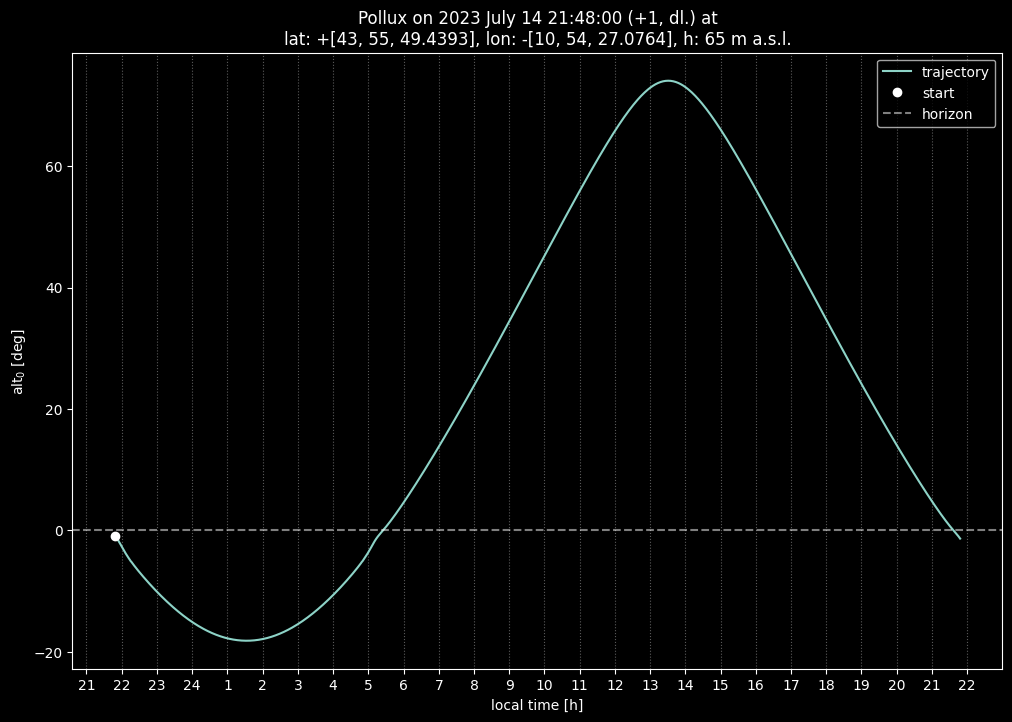

In [16]:
numpoint = 1000

out = 'local time'

lat = 43.93039980730644
lon = -10.907521220934262 
h = 65
obs = GeoPos(lon,lat,h)

name, ra, dec, prmt = import_data('targets.csv',sel=4)
obj = StarObj(name,[ra,dec],prmt)
obj.obj_info()
print()

timezone, dl_save = 1, True
date = Date([2023,7,14],[21,48,0],timezone=timezone,dl_save=dl_save)
print('Observation on ' + date.ut_to_local(timezone,dl_save,'str') + ' ==> ' + date.print_date())
alt, dayrange = trajectory(date,obs,obj,numpoint) 

## PLOT ##
hour = date.time.hour() 
N = 25 if hour <= (int(hour)+0.5) else 26
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar,epoch=date.epoch)
if out[:5] == 'local':
    hzone = timezone
    if dl_save: hzone += 1
elif out == 'UT':
    hzon = 0

plt.figure(figsize=[12,8])
ax = plt.axes()
ax.set_facecolor('black')
titledate = date.print_date() if out == 'UT' else date.ut_to_local(timezone,dl_save,'str')
plt.title(obj.name + ' on ' + titledate  + f" at\nlat: {obs.lat.print_angle('deg')}, lon: {obs.lon.print_angle('deg')}, h: {obs.h} m a.s.l.")

plt.plot(dayrange,alt.deg,label='trajectory')
plt.plot(dayrange[0],alt.deg[0],'ow',label='start')

labelticks = ticks.time.hour() + hzone
labelticks = np.where(labelticks >= 24, labelticks-24, labelticks)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,color='white',label='horizon')
plt.xticks(ticks.jd,np.round(labelticks,0).astype(int))
plt.xlabel(out + ' [h]')
plt.ylabel('alt$_0$ [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)
plt.legend(numpoints=1)

plt.show()

### <a id='toc1_3_3_'></a>[III.2.5 Transit, rising and setting](#toc0_)

In [17]:
def tran_ris_set(date: Date, obs_pos: GeoPos, obj: StarObj, results: bool = False, iter: int = 3) -> Time:
        date = date.copy()
        lon = obs_pos.lon
        lat = obs_pos.lat
        h0 = refraction_corr(Angles(0.,'deg',lim=90),obs_pos.h, alt0=True)

        tmpdate = Date(date.date,0.)
        Dt = time_correction(tmpdate.date[0])
        GHA = Green_HA(tmpdate,True)
        
        tmpdate = Date(date.date,0.,timetype='TD')
        jd = tmpdate.jd
        a1, d1 = obj.coor_in_date(tmpdate-1)
        a2, d2 = obj.coor_in_date(tmpdate)
        a3, d3 = obj.coor_in_date(tmpdate+1)
        del tmpdate

        cosH0 = (np.sin(h0.rad) - np.sin(lat.rad)*np.sin(d2.rad)) / (np.cos(lat.rad)*np.cos(d2.rad))
        
        # transit
        mt = (a2 + lon - GHA).deg / 360        
        if abs(mt) > 1:
            mt -= np.sign(mt)
        elif mt < 0:
            mt += 1
        for k in range(iter):
            LST = GHA.deg + 360.985647*mt
            if LST > 360:
                LST -= 360*(LST//360)
            LST = HAngles(LST,'deg')
            n = mt + Dt/Time.DAYSEC
            a = interpole_three([a1.deg,a2.deg,a3.deg],n+jd,[jd-1,jd,jd+1])
            a = HAngles(a,'deg')
            H = LST - lon - a
            Dmt = - H.deg/360
            mt += Dmt
            if abs(mt) > 1:
                mt -= np.sign(mt)
            elif mt < 0:
                mt += 1

        time = date.time
        if mt*24 < time.hour():
            mt += 1
        m = Time(mt*Time.DAYSEC)

        if results:
            print()
            transit = Date(date.date,m,calendar=date.calendar,epoch=date.epoch)
            print('transit:\t' + transit.print_date() + ' ==> ' + transit.ut_to_local(timezone,dl_save,'str'))

        # rising and setting
        if abs(cosH0) <= 1:
            H0 = HAngles(np.arccos(cosH0),'rad',lim=180)
            mr = mt - H0.deg/360
            ms = mt + H0.deg/360
            m = np.array([mr,ms])
            m = np.where(abs(m) > 1, m-np.sign(m), m)
            m = np.where(m < 0, m+1, m)
            for k in range(iter):
                LST = GHA.deg + 360.985647*m
                LST = np.where(LST > 360, LST - 360*(LST//360), LST)               
                LST = HAngles(LST,'deg')
                n = m + Dt/Time.DAYSEC
                a = np.array([interpole_three([a1.deg,a2.deg,a3.deg],ni+jd,[jd-1,jd,jd+1]) for ni in n])
                a = HAngles(a,'deg')
                d = np.array([interpole_three([d1.deg,d2.deg,d3.deg],ni+jd,[jd-1,jd,jd+1]) for ni in n])
                d = HAngles(d,'deg',lim=90) 
                H = LST - lon - a
                h = np.arcsin(np.sin(lat.rad)*np.sin(d.rad) + np.cos(lat.rad)*np.cos(d.rad)*np.cos(H.rad))
                h = Angles(h,'rad',lim=90)
                Dm = (h-h0).deg / (360 * (np.cos(d.rad)*np.cos(lat.rad)*np.sin(H.rad)))
                m += Dm
                m = np.where(abs(m) > 1, m-np.sign(m), m)
                m = np.where(m < 0, m+1, m)
            
            m = np.where(m*24 < time.hour(), m+1, m)
            m = Time(m*Time.DAYSEC)
            
            if results:
                mr, ms = m.val
                rising  = Date(date.date,Time(mr),calendar=date.calendar,epoch=date.epoch)
                setting = Date(date.date,Time(ms),calendar=date.calendar,epoch=date.epoch)

                event = [rising,setting]
                names = ['rising ','setting']
                for i in range(2):
                    print(names[i] + ':\t' + event[i].print_date() + ' ==> ' + event[i].ut_to_local(timezone,dl_save,'str'))
            m.val = np.append(mt*Time.DAYSEC,m.val)
        return m


2023 July 14 21:48:00 (+1, dl.)

transit:	2023 July 15 11:34:45.1773 UT ==> 2023 July 15 13:34:45.1773 (+1, dl.)
rising :	2023 July 15 03:28:48.4715 UT ==> 2023 July 15 05:28:48.4715 (+1, dl.)
setting:	2023 July 15 19:40:41.8797 UT ==> 2023 July 15 21:40:41.8797 (+1, dl.)


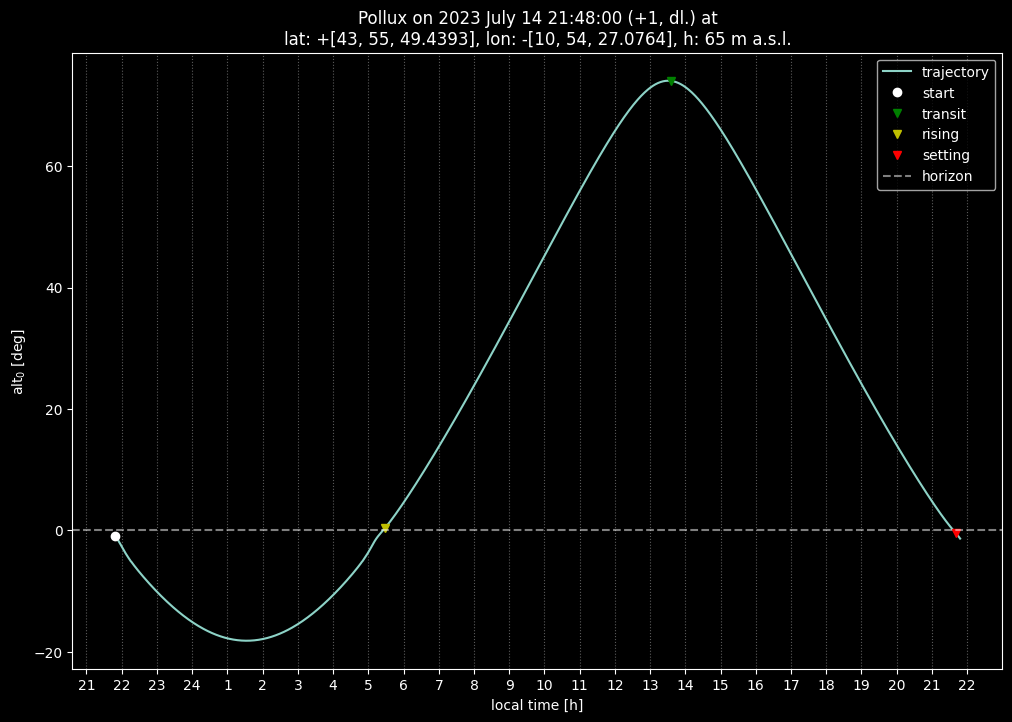

2023 July 14 20:03:00 UT

transit:	2023 July 15 11:34:45.1773 UT ==> 2023 July 15 13:34:45.1773 (+1, dl.)
rising :	2023 July 15 03:28:48.4715 UT ==> 2023 July 15 05:28:48.4715 (+1, dl.)
setting:	2023 July 15 19:40:41.8797 UT ==> 2023 July 15 21:40:41.8797 (+1, dl.)


In [18]:
print(date.ut_to_local(timezone,dl_save,'str'))

m = tran_ris_set(date,obs,obj,True)
event = Date(date.date,m)
ealt = compute_alt(event,obs,obj,True)

# print(ealt.deg[1:]*3600,'arcsec')
# print(ealt.deg[0],alt.deg.max())

## PLOT ##
hour = date.time.hour() 
N = 25 if hour <= (int(hour)+0.5) else 26
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar,epoch=date.epoch)

plt.figure(figsize=[12,8])
ax = plt.axes()
ax.set_facecolor('black')
titledate = date.print_date() if out == 'UT' else date.ut_to_local(timezone,dl_save,'str')
plt.title(obj.name + ' on ' + titledate  + f" at\nlat: {obs.lat.print_angle('deg')}, lon: {obs.lon.print_angle('deg')}, h: {obs.h} m a.s.l.")

plt.plot(dayrange,alt.deg,label='trajectory')
plt.plot(dayrange[0],alt.deg[0],'ow',label='start')
if type(m.val) != np.ndarray:
    plt.plot(event.jd,ealt.deg,'vg',label='transit')
else:
    plt.plot(event.jd[0],ealt.deg[0],'vg',label='transit')
    plt.plot(event.jd[1],ealt.deg[1],'vy',label='rising')
    plt.plot(event.jd[2],ealt.deg[2],'vr',label='setting')


labelticks = ticks.time.hour() + hzone
labelticks = np.where(labelticks >= 24, labelticks-24, labelticks)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,color='white',label='horizon')
plt.xticks(ticks.jd,np.round(labelticks,0).astype(int))
plt.xlabel(out + ' [h]')
plt.ylabel('alt$_0$ [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)
plt.legend(numpoints=1)

plt.show()

tmpdate = date + Time(15*60)
print(tmpdate.print_date())

m = tran_ris_set(tmpdate,obs,obj,True)
event = Date(tmpdate.date,m)
ealt = compute_alt(event,obs,obj,True)

# print(ealt.deg[1:]*3600,'arcsec')
# print(ealt.deg[0],alt.deg.max())



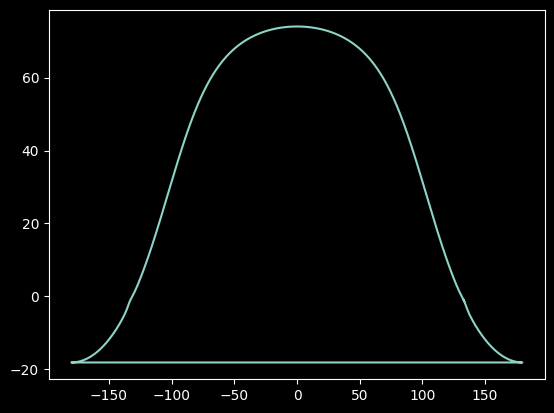

In [19]:
def compute_az(date: Date, obs_pos: GeoPos, obj: StarObj, numpoint: int = 1000):
    date = date.copy()
    
    lat = obs_pos.lat
    lon = obs_pos.lon

    dayrange = date.jd + np.linspace(0,1,numpoint)
    dayrange = Date(jd=dayrange,timetype=date.time.tytime,calendar=date.calendar,epoch=date.epoch)


    dec = obj.coor_in_date(dayrange,sel='dec')
       
    HA = obj.lha(dayrange,lon)
    
    az = np.arctan2(np.sin(HA.rad), (np.cos(HA.rad)*np.sin(lat.rad) - np.tan(dec.rad)*np.cos(lat.rad)))
    return HAngles(az,'rad')

az = compute_az(date,obs,obj)

plt.plot(az.deg,alt.deg)
plt.show()

## <a id='toc1_4_'></a>[IV. Sun](#toc0_)

### <a id='toc1_4_1_'></a>[IV.I Twilight](#toc0_)

## <a id='toc1_5_'></a>[V. Moon](#toc0_)

### <a id='toc1_5_1_'></a>[V.I Moon Phases](#toc0_)